In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

# importing comet variables stored in .env file
comet_api_key =  os.getenv("COMET_API_KEY")
comet_project_name = os.getenv("COMET_PROJECT_NAME")
comet_workspace_name = os.getenv("COMET_WORKSPACE_NAME")
# print(api_key)
# print(project_name)
# print(workspace_name)

In [ ]:
# Integrating comet to track results
from comet_ml import Experiment
experiment = Experiment(
  api_key=comet_api_key,
  project_name=comet_project_name,
  workspace=comet_workspace_name,
  auto_metric_logging=True,
  auto_param_logging=True,
  auto_histogram_weight_logging=True,
  auto_histogram_gradient_logging=True,
  auto_histogram_activation_logging=True,
  auto_histogram_epoch_rate=True,
  log_code=True
)

# setting the experiment name
experiment.set_name("vgg19_v1_fer")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/nikhil527/image-emotion-classifier/71760745a4ee489dae2b9e54125044e8



COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information


In [23]:
# Importing the packages required for the project
import keras.backend as K
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import Precision, Recall, AUC

In [18]:
import sys 
import os

# Adding the parent directory to the sys.path to access helper_functions
parent_directory = os.path.dirname(os.getcwd())

# Adds our parent directory to the list of paths that python searches for modules
sys.path.append(parent_directory) 

from helper_functions import *

In [5]:
# performing some preprocessing and data augmentation techniques to help our
# model generalize better

# rotation_range, width_shift_range, height_shift_range, zoom_range: 
# These parameters will randomly rotate, shift, and zoom images during training 
# to increase variations in our dataset

# horizontal_flip, vertical_flip 
# This will randomly flip images horizontally and vertically. 
# All these techniques will help us in generating new data to help the 
# model generalize better on real-world scenarios

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,         
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

train_dataset  = train_datagen.flow_from_directory(directory = 'c:/users/saini/onedrive/documents/masters/first semester/machine learning/datasets/fer2013/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

valid_dataset = valid_datagen.flow_from_directory(directory = 'c:/users/saini/onedrive/documents/masters/first semester/machine learning/datasets/fer2013/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

test_dataset = test_datagen.flow_from_directory(directory = 'c:/users/saini/onedrive/documents/masters/first semester/machine learning/datasets/fer2013/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)



Found 22967 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
# getting the labels for our training dataset
print(train_dataset.class_indices)
class_labels_index = train_dataset.class_indices
print(class_labels_index)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [7]:
# Setting our base model as vgg16 with pretrained weights 
# from imagenet

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# making all the layers of vgg19 non trainable
for layer in base_model.layers:
    layer.trainable = False

model = base_model.layers[-2].output
model = GlobalAveragePooling2D()(model)
model = Dense(7, activation='softmax', name='output_layer')(model)

model = Model(inputs=base_model.input, outputs= model)

In [8]:
# we are using early stopping to stop the training process if the model
# doesnt improve within 10 epochs
es = EarlyStopping(monitor='val_accuracy', min_delta = 0.00005, patience = 10, verbose = 1, restore_best_weights = True)

lrd = ReduceLROnPlateau(monitor='val_loss', patience=6, min_lr=1e-10)

In [9]:
# we are using SGD (Stochastic Gradient Descent) as our optimizer
# we have included momentum to speed up the convergence of SGD
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)


In [10]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

In [12]:
# training our model
with tf.device('/GPU:0'):
    history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 50, verbose = 1,callbacks=[es, lrd])

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE
COMET WARNING: auto_histogram_gradient_logging is True, but inputs and targets are not available; unable to log gradients
COMET WARNING: auto_histogram_activation_logging is True, but inputs are not available; unable to log activations


Epoch 1/50
359/359 [==============================] - 305s 834ms/step - loss: 1.8070 - accuracy: 0.2467 - val_loss: 1.7656 - val_accuracy: 0.2749 - lr: 0.0010
Epoch 2/50
359/359 [==============================] - 99s 275ms/step - loss: 1.7544 - accuracy: 0.2784 - val_loss: 1.7354 - val_accuracy: 0.3005 - lr: 0.0010
Epoch 3/50
359/359 [==============================] - 63s 174ms/step - loss: 1.7364 - accuracy: 0.2946 - val_loss: 1.7265 - val_accuracy: 0.3024 - lr: 0.0010
Epoch 4/50
359/359 [==============================] - 70s 195ms/step - loss: 1.7208 - accuracy: 0.2976 - val_loss: 1.7169 - val_accuracy: 0.3085 - lr: 0.0010
Epoch 5/50
359/359 [==============================] - 76s 210ms/step - loss: 1.7199 - accuracy: 0.2986 - val_loss: 1.7142 - val_accuracy: 0.3102 - lr: 0.0010
Epoch 6/50
359/359 [==============================] - 109s 304ms/step - loss: 1.7148 - accuracy: 0.3063 - val_loss: 1.6999 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 7/50
359/359 [==============================

COMET ERROR: File-like upload failed: ConnectionError(ProtocolError('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))), url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


359/359 [==============================] - 90s 249ms/step - loss: 1.7089 - accuracy: 0.3078 - val_loss: 1.7054 - val_accuracy: 0.3128 - lr: 0.0010
Epoch 10/50
359/359 [==============================] - 98s 273ms/step - loss: 1.7088 - accuracy: 0.3099 - val_loss: 1.6905 - val_accuracy: 0.3188 - lr: 0.0010
Epoch 11/50
359/359 [==============================] - 106s 293ms/step - loss: 1.7069 - accuracy: 0.3089 - val_loss: 1.7023 - val_accuracy: 0.3168 - lr: 0.0010
Epoch 12/50
359/359 [==============================] - 103s 287ms/step - loss: 1.7031 - accuracy: 0.3082 - val_loss: 1.6895 - val_accuracy: 0.3268 - lr: 0.0010
Epoch 13/50
359/359 [==============================] - 107s 297ms/step - loss: 1.7012 - accuracy: 0.3129 - val_loss: 1.6971 - val_accuracy: 0.3107 - lr: 0.0010
Epoch 14/50
359/359 [==============================] - 98s 273ms/step - loss: 1.7018 - accuracy: 0.3101 - val_loss: 1.6921 - val_accuracy: 0.3160 - lr: 0.0010
Epoch 15/50
359/359 [==============================] - 

In [13]:
# saving our model  
model.save("model_v1_vgg_19.h5")

In [14]:
# stopping our comet ml experiment
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nikhil527/image-emotion-classifier/71760745a4ee489dae2b9e54125044e8
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [25]                 : (0.24674533307552338, 0.3228980600833893)
COMET INFO:     batch_accuracy [900]          : (0.125, 0.4375)
COMET INFO:     batch_loss [900]              : (1.6038196086883545, 2.113654136657715)
COMET INFO:     epoch_duration [25]           : (60.25, 304.17099999999846)
COMET INFO:     loss [25]                     : (1.6836179494857788, 1.8070077896118164)
COMET INFO:     lr [25]                       : (0.00010000000474974513, 0.0010000000474974513)
COMET INFO:     val_acc

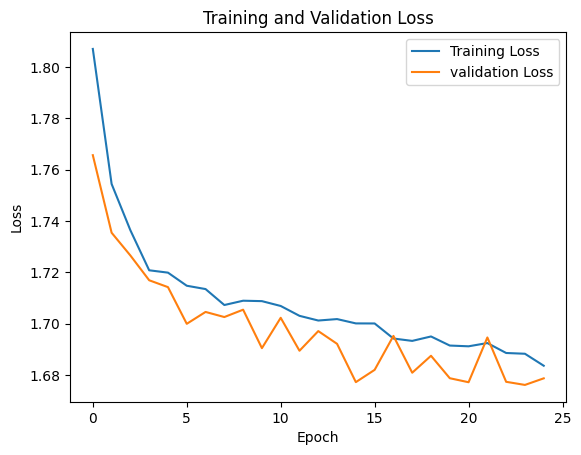

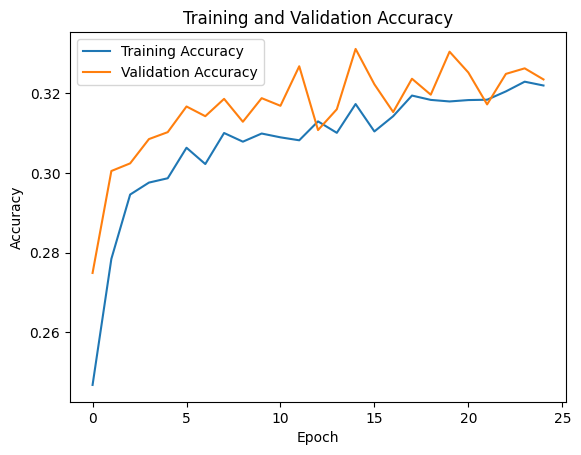

In [15]:
plot_graph(history)

In [16]:
# loading images and labels from test set
first_batch_images, first_batch_labels = next(test_dataset)

Text(0.5, 1.0, 'sad')

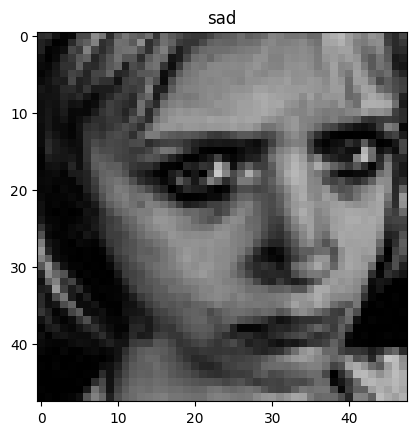

In [24]:
def compute_label(label_array, class_indexes):
    predicted_class_index = np.argmax(label_array)
    predicted_class = list(class_indexes.keys())[predicted_class_index]
    return predicted_class
plt.imshow(first_batch_images[5])
plt.title(compute_label(first_batch_labels[5], class_labels_index))

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


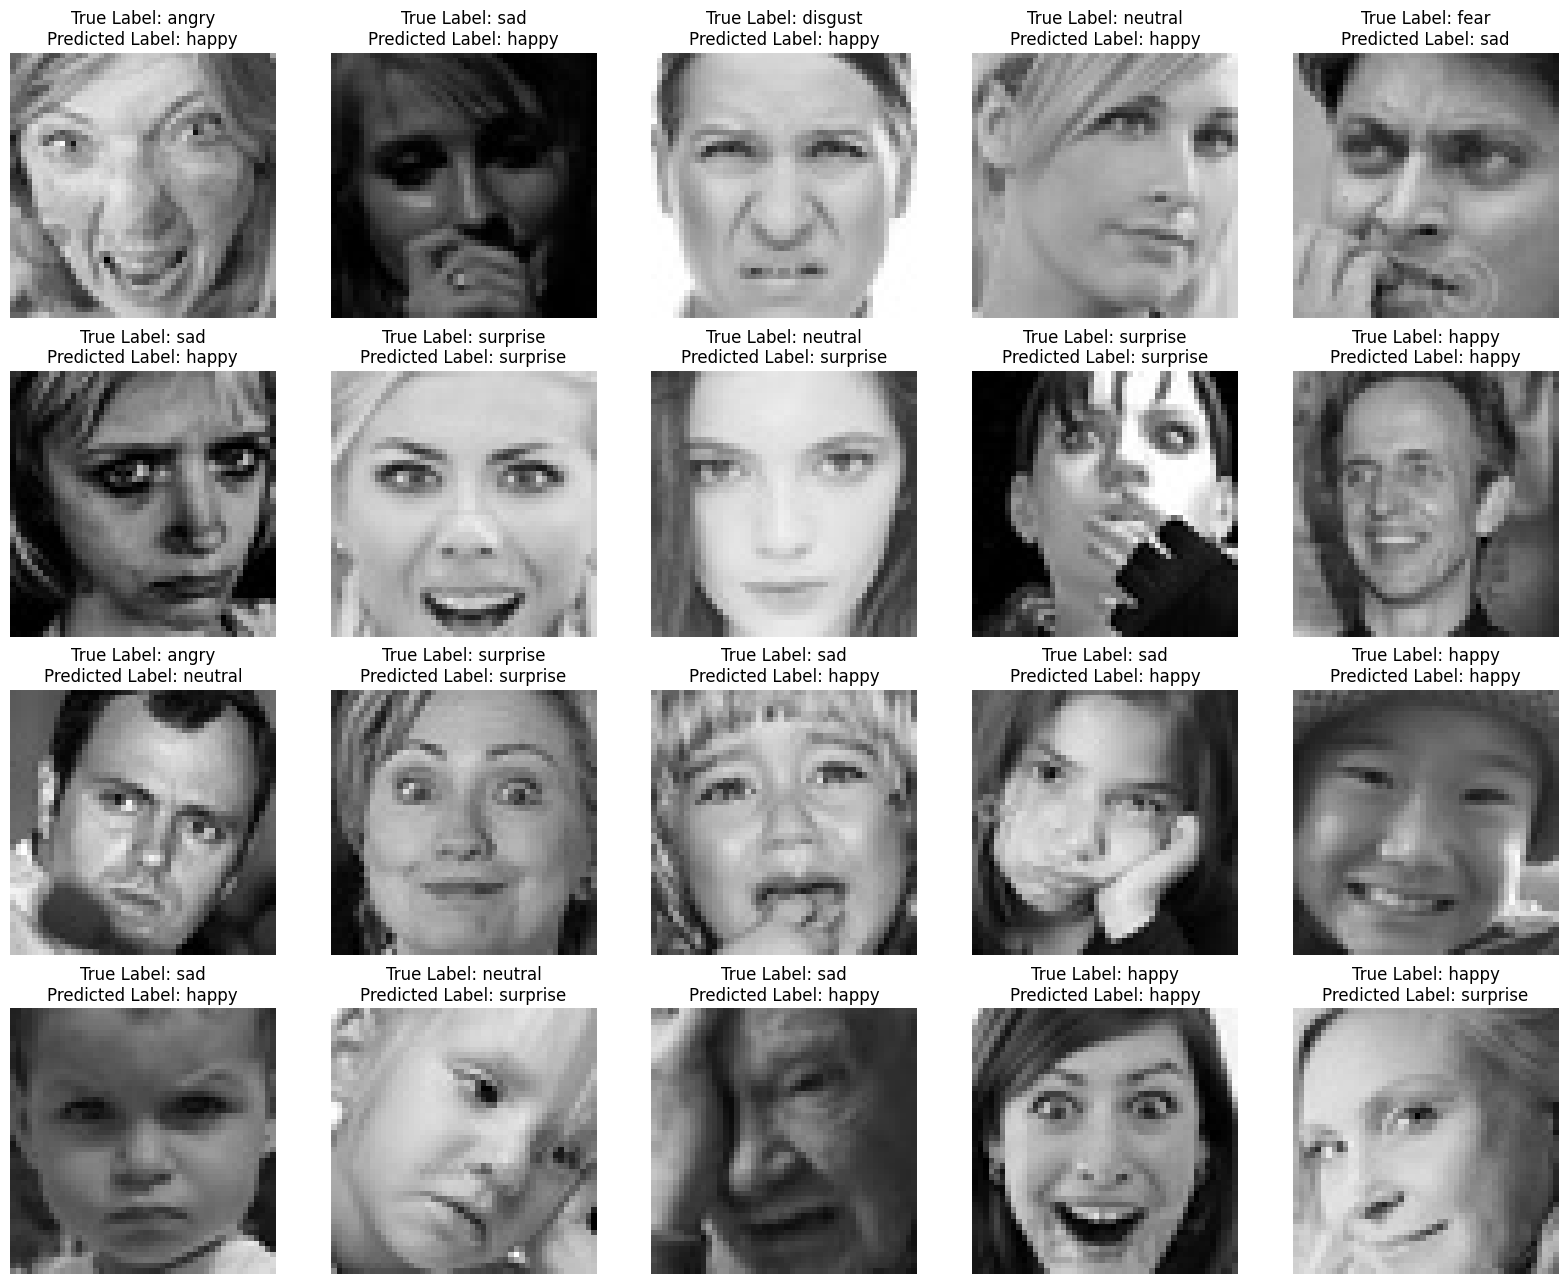

In [27]:
# predicting our models result on the test dataset
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.imshow(first_batch_images[i], cmap='gray')
    plt.axis('off')
    true_label = compute_label(first_batch_labels[i], class_labels_index)
    predicted_label = compute_label(model.predict(first_batch_images[i].reshape((1, 48, 48, 3))), class_labels_index)
    title = f"True Label: {true_label}\nPredicted Label: {predicted_label}"
    plt.title(title)

1/1 [==============================] - 0s 34ms/step


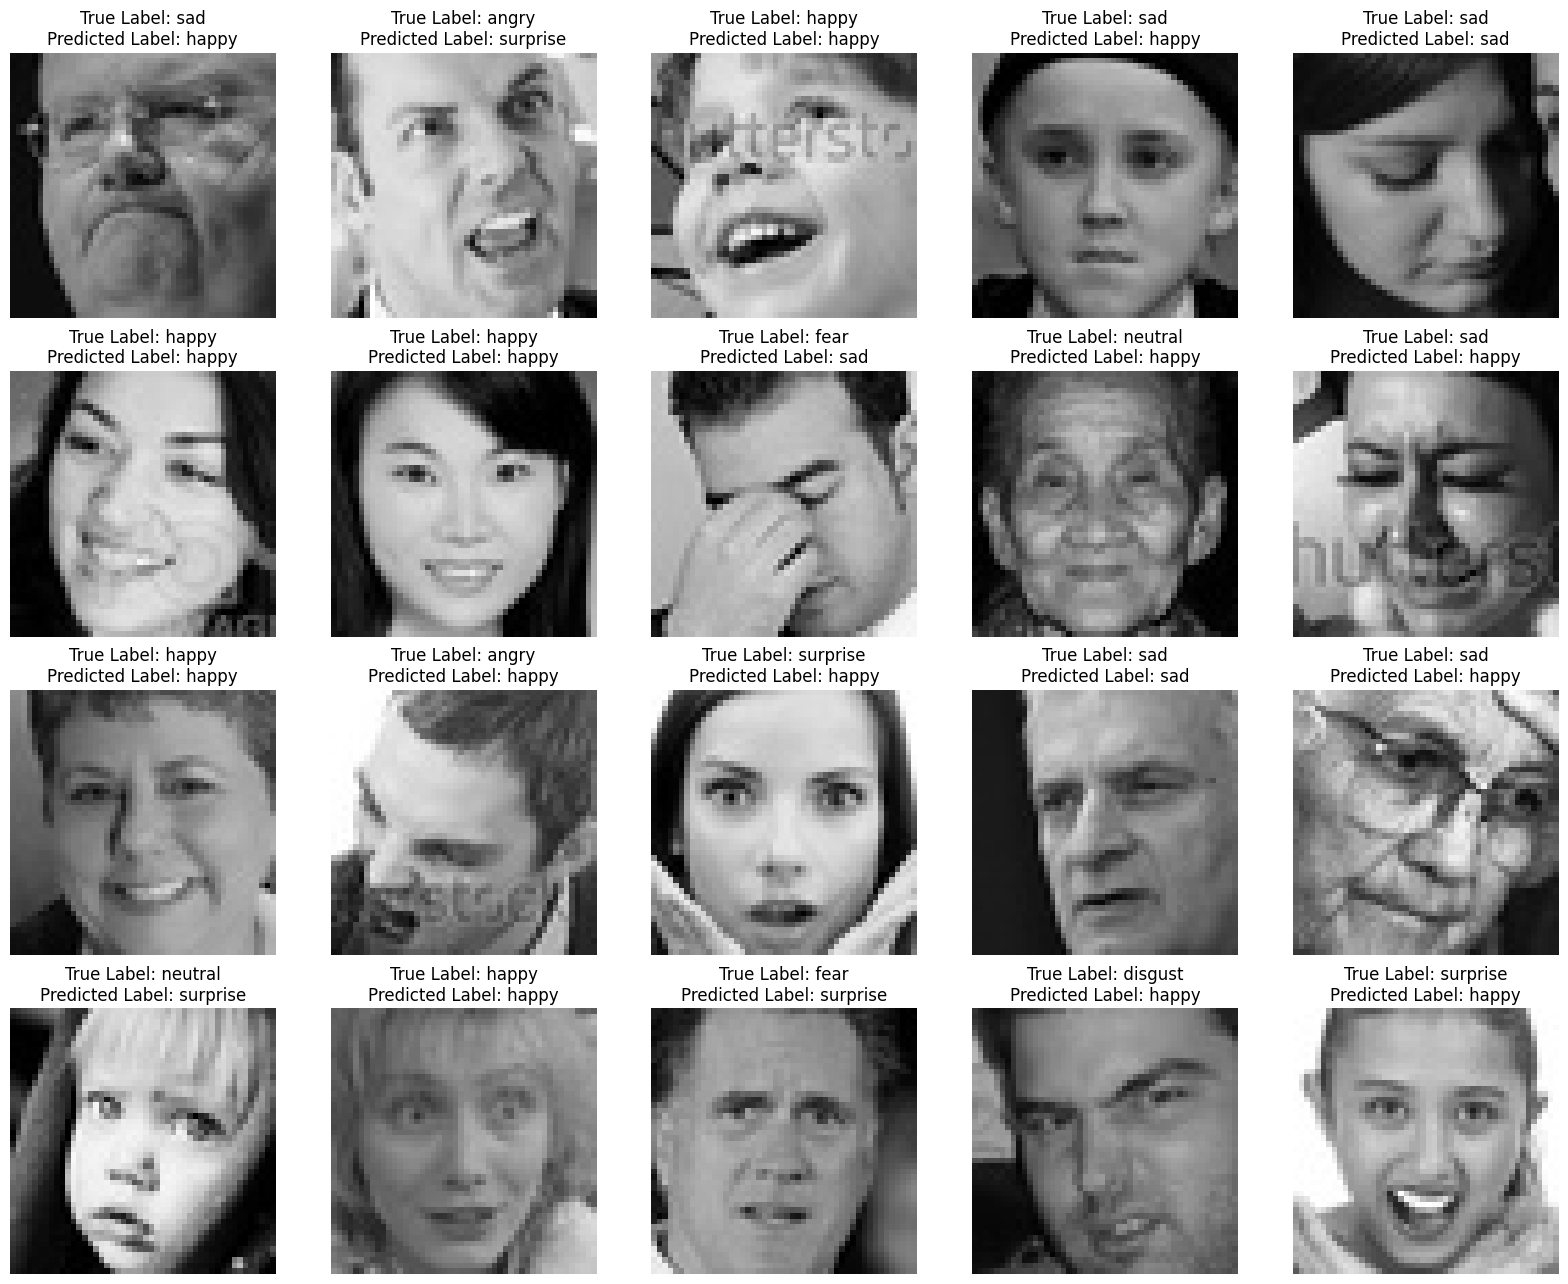

In [28]:
plt.figure(figsize=(20, 20))
j=1
for i in range(21, 41):
    plt.subplot(5,5,j)
    j = j+1
    plt.imshow(first_batch_images[i], cmap='gray')
    plt.axis('off')
    true_label = compute_label(first_batch_labels[i], class_labels_index)
    predicted_label = compute_label(model.predict(first_batch_images[i].reshape((1, 48, 48, 3))), class_labels_index)
    title = f"True Label: {true_label}\nPredicted Label: {predicted_label}"
    plt.title(title)

1/1 [==============================] - 0s 31ms/step


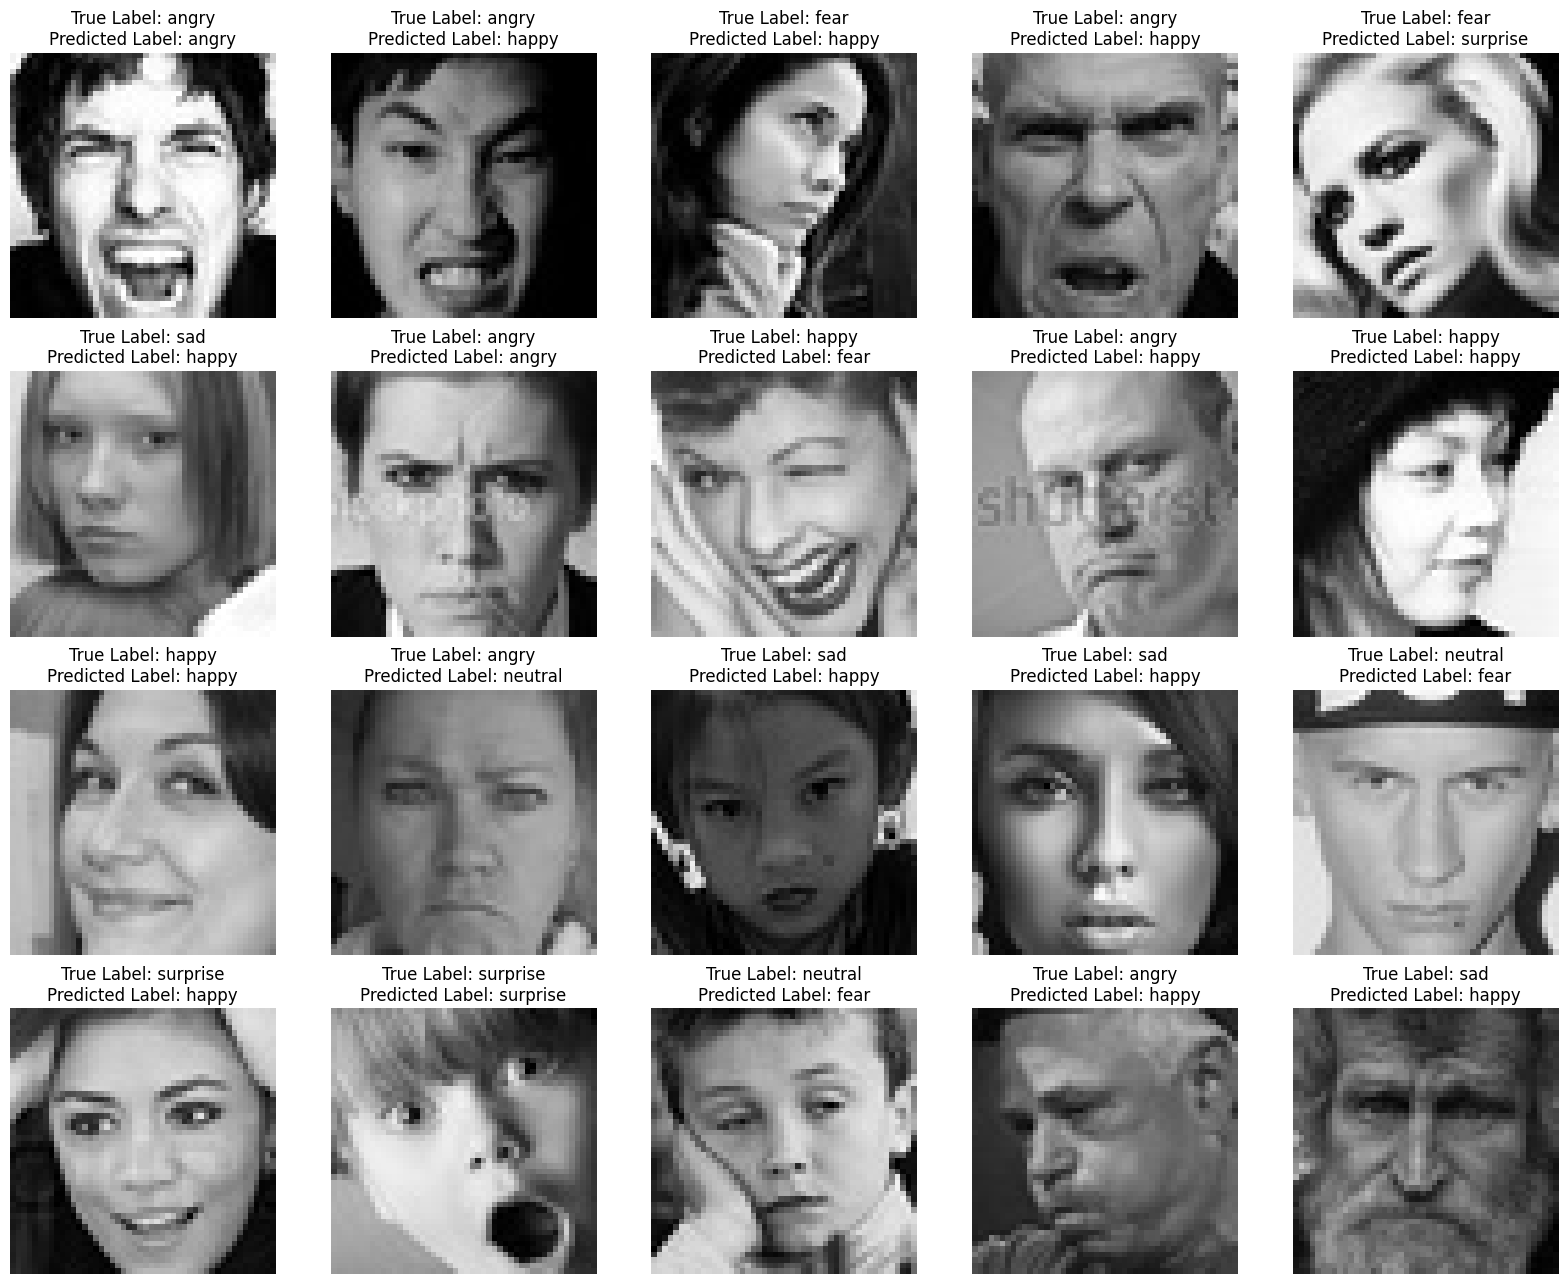

In [29]:
plt.figure(figsize=(20, 20))
j=1
for i in range(41, 61):
    plt.subplot(5,5,j)
    j = j+1
    plt.imshow(first_batch_images[i], cmap='gray')
    plt.axis('off')
    true_label = compute_label(first_batch_labels[i], class_labels_index)
    predicted_label = compute_label(model.predict(first_batch_images[i].reshape((1, 48, 48, 3))), class_labels_index)
    title = f"True Label: {true_label}\nPredicted Label: {predicted_label}"
    plt.title(title)